# **Курсовая работа по дисциплине "Автоматика и регулирование ЖРД"**

### Исходные данные

In [1]:
# Параметры возмущения
p1_0=400e3
A=100e3
T=0.1
# Давления в трубах
p2 = 200e3
p3 = 100e3
# Параметры газа
k = 1.4
R = 297
c = 1200
mгаз = 0.0034
Vг0 = 0.002 #2 литра
Tгаз0 = 293
# Параметры демпфера в начале
Vд_0 = 0
mд_0 = 0
# Параметры жидкоси
Vж0 = 0.004 #4 литра
ρж = 820
# Коэффициент инерционности
j1 = 400
j2 = 400
j3 = 400
jд = 20
# Коэффициент гидросопротивления
ξ1 = 1000
ξ2 = 1000
ξ3 = 1000
ξд = 1000

#### Заметка

In [42]:
# Для АЧХ ФЧХ
# def p1(t):
#     p1 = p1_0 + A *np.sin(2*np.pi * t / T) 
#     return p1

### Стационарная задача. Решением стационарной задачи являются начальными условиями задачи.

In [2]:
from scipy.optimize import fsolve
import numpy as np
import random


# Определяем функцию для fsolve
def equations(vars):
    m1_0, m2_0, m3_0, p4_0, pgas_0 = vars
    eq1 = m1_0 + m2_0 - m3_0
    eq2 = p4_0 - pgas_0
    eq3 = p1_0 - p4_0 - ξ1*m1_0**2
    eq4 = p4_0 - p3 - ξ3*m3_0**2
    eq5 = p2 - p4_0 - ξ2*m2_0**2
    return [eq1, eq2, eq3, eq4, eq5]


# Вводим случайные приближения
initial_guess = [random.random() for _ in range(5)]

# Пока корни меньше нуля менять случайные приближения
while min(fsolve(equations, initial_guess)) <= 0:
  initial_guess = [random.random() for _ in range(5)]
  
# Вывод решения
solution = fsolve(equations, initial_guess)
print("Solution:", solution)
# Присваивание значений переменным
m1_0 = solution[0]
m2_0 = solution[1]
m3_0 = solution[2]
p4_0 = solution[3]
pgas_0 = solution[4]
# Вывод переменных
print("m1_0=", m1_0) 
print("m2_0=", m2_0) 
print("m3_0=", m3_0)
print("p4_0=", p4_0) 
print("pgas_0=", pgas_0)


Solution: [1.47059618e+01 4.03315164e+00 9.15067275e+00 1.83734484e+05
 1.83734775e+05]
m1_0= 14.705961838733687
m2_0= 4.0331516381642025
m3_0= 9.150672749657177
p4_0= 183734.48427803494
pgas_0= 183734.7753311396


/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


### Динамическая задача с демпфером.

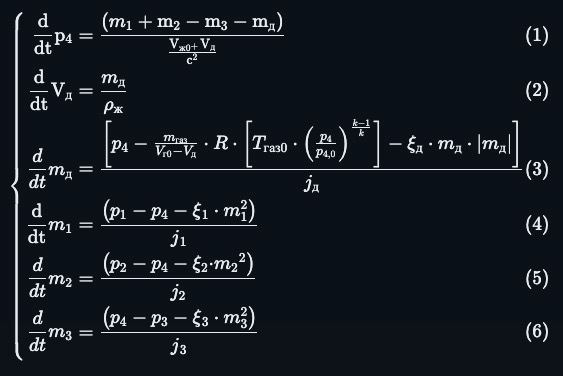

In [3]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Определение системы дифференциальных уравнений
def system(y, t):
    # Искомые параметры
    p4, Vд, mд, m1, m2, m3 = y
    # Дифференциальные уравнения
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - ξд * mд * abs(mд)) / jд
    d_m1 = (p1(t) - p4 - ξ1 * m1*abs(m1)) / j1
    d_m2 = (p2 - p4 - ξ2 * m2*abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3*abs(m3)) / j3
    # Возвращение значений искомых параметров
    return [d_p4, d_Vд, d_mд, d_m1, d_m2, d_m3]

# Определение возмущающей функции
def p1(t):
    if t<0:
        p1=0
    if 0 <= t < T/2:
        p1 = (p1_0 + A*(np.sin(2*np.pi / T*(t-T/4)) + 1))
    else:
        p1 = (p1_0 + 2*A)
    return p1

# Параметры вычисления. Время и шаг.
t_end = 1
h = 1000000

# Задаются начальные условия и массив точек по времени.
y0 = [p4_0, Vд_0, mд_0, m1_0, m2_0, m3_0]
t = np.linspace(0, t_end, h)

# Решение системы
sol = odeint(system, y0, t)

# Вывод полученных значений
print(pd.DataFrame(data=sol))

max_p4_0 = np.max(sol[:, 0])
print('Max p4 =', max_p4_0)

                    0             1         2          3         4         5
0       183734.484278  0.000000e+00  0.000000  14.705962  4.033152  9.150673
1       187185.993462  1.121885e-12  0.001856  14.705958  4.033147  9.150677
2       190636.802277  4.585427e-12  0.003846  14.705945  4.033134  9.150690
3       194086.853888  1.055191e-11  0.005970  14.705923  4.033113  9.150712
4       197536.086886  1.919570e-11  0.008228  14.705893  4.033083  9.150742
...               ...           ...       ...        ...       ...       ...
999995            NaN           NaN       NaN        NaN       NaN       NaN
999996            NaN           NaN       NaN        NaN       NaN       NaN
999997            NaN           NaN       NaN        NaN       NaN       NaN
999998            NaN           NaN       NaN        NaN       NaN       NaN
999999            NaN           NaN       NaN        NaN       NaN       NaN

[1000000 rows x 6 columns]
Max p4 = nan


/var/folders/22/bwm475vx0q7c958ns0w5lp4c0000gn/T/ipykernel_33020/494373896.py:13: RuntimeWarning: invalid value encountered in scalar power
  d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - ξд * mд * abs(mд)) / jд


#### Графики

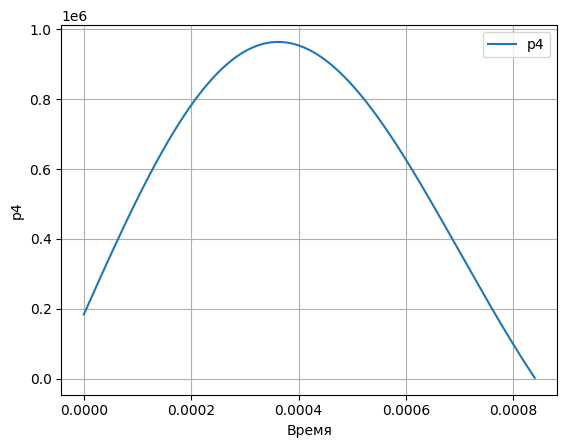

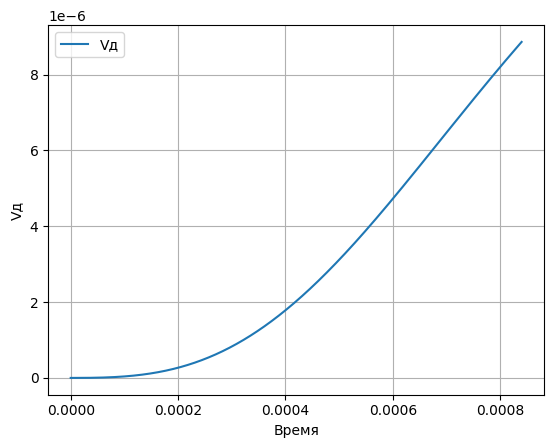

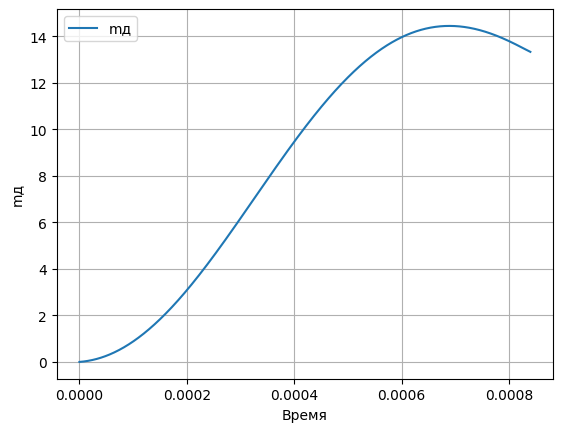

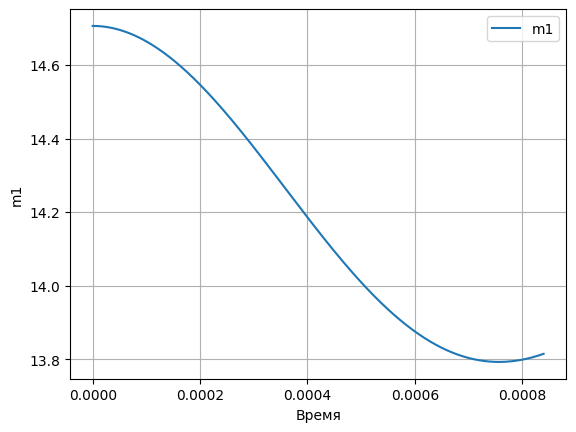

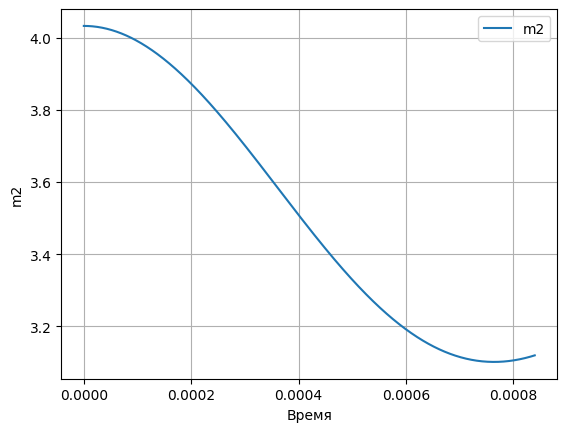

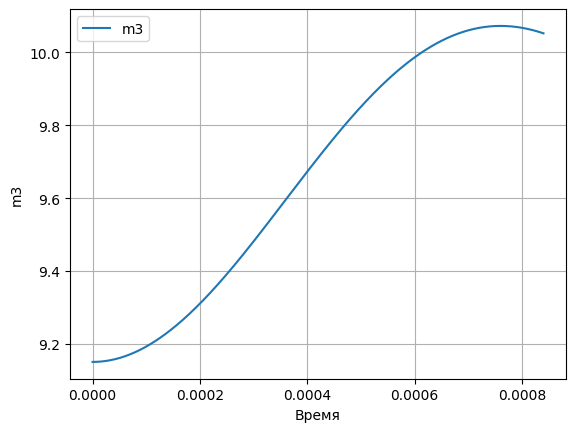

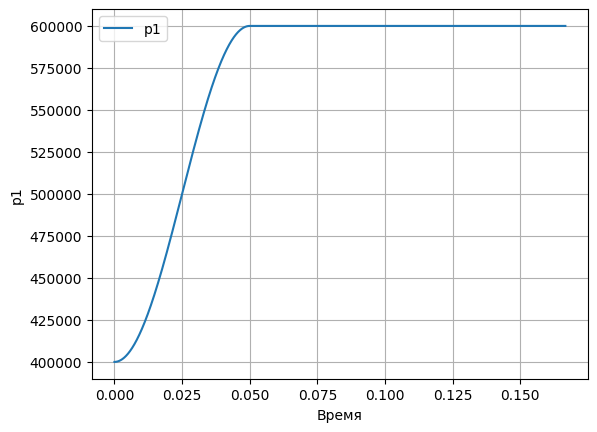

In [4]:
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(t, sol[:, 0], "p4")
plot(t, sol[:, 1], "Vд")
plot(t, sol[:, 2], "mд")
plot(t, sol[:, 3], "m1")
plot(t, sol[:, 4], "m2")
plot(t, sol[:, 5], "m3")
# plot(t, sol[:, 6], "pgas_0")
plot(t[:int(h/6)], [p1(t) for t in t][:int(h/6)], "p1")

### Динамическая задача без демпфера

In [21]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Определение системы дифференциальных уравнений
def system(y, t):
    # Искомые параметры
    p4, m1, m2, m3 = y
    # Дифференциальные уравнения
    d_p4 = (m1 + m2 - m3 - 0) / ((Vж0 + 0) / c**2)
    d_m1 = (p1(t) - p4 - ξ1 * m1*abs(m1)) / j1
    d_m2 = (p2 - p4 - ξ2 * m2*abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3*abs(m3)) / j3
    # Возвращение значений искомых параметров
    return [d_p4, d_m1, d_m2, d_m3]

# Определение возмущающей функции
def p1(t):
    if t<0:
        p1=0
    if 0 <= t < T/2:
        p1 = (p1_0 + A*(np.sin(2*np.pi / T*(t-T/4)) + 1))
    else:
        p1 = (p1_0 + 2*A)
    return p1

# Параметры вычисления. Время и шаг.
t_end = 1
h = 1000000

# Задаются начальные условия и массив точек по времени.
y0 = [p4_0, m1_0, m2_0, m3_0]
t = np.linspace(0, t_end, h)

# Решение системы
sol = odeint(system, y0, t)

# Вывод полученных значений
# print(pd.DataFrame(data=sol))

max_p4_0 = np.max(sol[:, 0])
print('Max p4 =', max_p4_0)

Max p4 = 1550080.8421830893


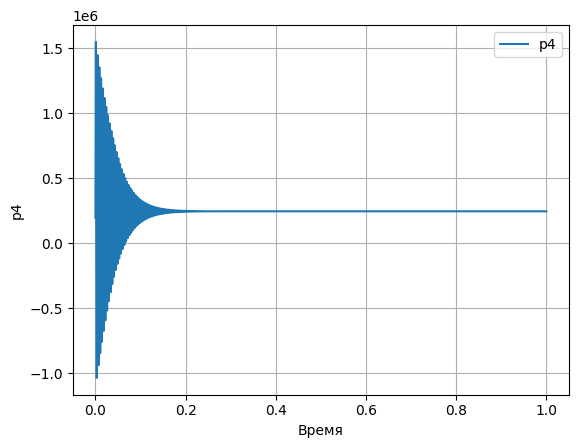

In [22]:
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(t, sol[:, 0], "p4")
# plot(t, sol[:, 1], "m1")
# plot(t, sol[:, 2], "m2")
# plot(t, sol[:, 3], "m3")
# # plot(t, sol[:, 6], "pgas_0")
# plot(t[:int(h/6)], [p1(t) for t in t][:int(h/6)], "p1")

### Построение синусоиды

In [48]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Определение возмущающей функции
def p11(t):
    if t<0:
        p11=0
    else:
          p11 = (p1_0 + A*(np.sin(2*np.pi / T*(t-T/4)) + 1))
    return p11
    

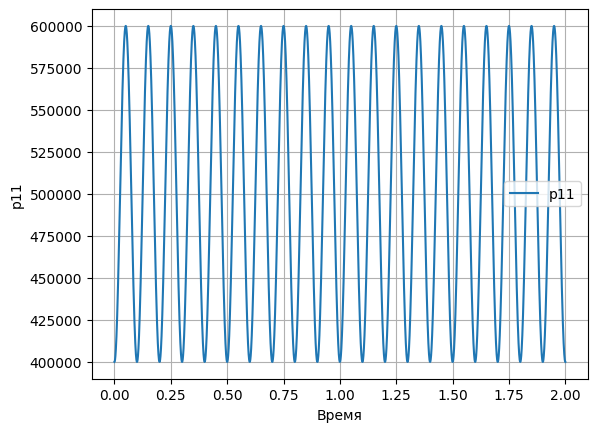

In [49]:
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()

# Параметры вычисления. Время и шаг.
t_end = 12
h = 6000000

t = np.linspace(0, t_end, h)

plot(t[:int(h/6)], [p11(t) for t in t][:int(h/6)], "p11")